In [1]:
import sys
sys.path.append('../scripts')
from spatioformer import SpatioformerModel
from cnn import CNNModel
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import scipy
from scipy.stats import gaussian_kde
import os

In [2]:
class MyDataset(Dataset):

    def __init__(self, pickle_dir='../data_to_release/samples_to_release.pkl'):
        with open(pickle_dir, 'rb') as f:         
            self.imgs = pickle.load(f)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        row = self.imgs.loc[idx]
        array, lon_4326, lat_4326, richness = row['Image'], row['Longitude'], row['Latitude'], row['Richness']

        return torch.from_numpy(array.astype('float32')), richness.astype('float32'), torch.from_numpy(lon_4326.astype('float32')), torch.from_numpy(lat_4326.astype('float32'))

    
def get_dataloaders(
        batch_size=2048,
        num_workers=os.cpu_count(),
        split_file='../data_to_release/split_to_release.pkl',
        ):
    
    dataset = MyDataset()
    
    with open(split_file, 'rb') as f:         
        split = pickle.load(f)

    train_indices = split['train']
    val_indices = split['val']
    test_indices = split['test']
    
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler)
    test_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders()

In [3]:
%%time
# Spatioformer - with geolocational encoding
net = SpatioformerModel(device='cpu', if_encode=True)
net.load_state_dict(torch.load('../models/spatioformer/example/model.pth', map_location=torch.device('cpu')))
net.eval()

true_spatioformer = []
predicted_spatioformer = []

for test_step_counter, (array, richness, lon, lat) in enumerate(test_loader):
    predicted = net(array, lon, lat).squeeze(-1)
    true_spatioformer.extend(richness.detach().numpy().tolist())
    predicted_spatioformer.extend(predicted.detach().numpy().tolist())
    
# Coefficient of correlation (r)
correlation_coefficient = np.corrcoef(true_spatioformer, predicted_spatioformer)[0, 1]
# Coefficient of determination (r2)
coefficient_of_determination = r2_score(true_spatioformer, predicted_spatioformer)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(true_spatioformer, predicted_spatioformer)
# Relative Absolute Error (RAE)
rae = mae / np.mean(np.abs(true_spatioformer))
# Mean Squared Error (MSE)
mse = mean_squared_error(true_spatioformer, predicted_spatioformer)
# Relative Squared Error (RSE)
rse = mse / np.mean(np.square(true_spatioformer))
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

{'Coefficient of correlation (r)': round(correlation_coefficient, 2),
 'Coefficient of determination (r2)': round(coefficient_of_determination, 2),
 'Mean Absolute Error (MAE)': round(mae, 2),
 'Relative Absolute Error (RAE)': round(rae, 2),
 'Mean Squared Error (MSE)': round(mse, 2),
 'Relative Squared Error (RSE)': round(rse, 2),
 'Root Mean Squared Error (RMSE)': round(rmse, 2)}

CPU times: user 13.6 s, sys: 11.1 s, total: 24.7 s
Wall time: 7.37 s


{'Coefficient of correlation (r)': 0.72,
 'Coefficient of determination (r2)': 0.5,
 'Mean Absolute Error (MAE)': 8.59,
 'Relative Absolute Error (RAE)': 0.31,
 'Mean Squared Error (MSE)': 128.27,
 'Relative Squared Error (RSE)': 0.12,
 'Root Mean Squared Error (RMSE)': 11.33}

In [4]:
%%time
# ViT - no geolocational encoding 
net = SpatioformerModel(device='cpu', if_encode=False)
net.load_state_dict(torch.load('../models/vit/example/model.pth', map_location=torch.device('cpu')))
net.eval()

true_vit = []
predicted_vit = []

for test_step_counter, (array, richness, lon, lat) in enumerate(test_loader):
    predicted = net(array, lon, lat).squeeze(-1)
    true_vit.extend(richness.detach().numpy().tolist())
    predicted_vit.extend(predicted.detach().numpy().tolist())
    
# Coefficient of correlation (r)
correlation_coefficient = np.corrcoef(true_vit, predicted_vit)[0, 1]
# Coefficient of determination (r2)
coefficient_of_determination = r2_score(true_vit, predicted_vit)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(true_vit, predicted_vit)
# Relative Absolute Error (RAE)
rae = mae / np.mean(np.abs(true_vit))
# Mean Squared Error (MSE)
mse = mean_squared_error(true_vit, predicted_vit)
# Relative Squared Error (RSE)
rse = mse / np.mean(np.square(true_vit))
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

{'Coefficient of correlation (r)': round(correlation_coefficient, 2),
 'Coefficient of determination (r2)': round(coefficient_of_determination, 2),
 'Mean Absolute Error (MAE)': round(mae, 2),
 'Relative Absolute Error (RAE)': round(rae, 2),
 'Mean Squared Error (MSE)': round(mse, 2),
 'Relative Squared Error (RSE)': round(rse, 2),
 'Root Mean Squared Error (RMSE)': round(rmse, 2)}

CPU times: user 14 s, sys: 15.2 s, total: 29.2 s
Wall time: 8.75 s


{'Coefficient of correlation (r)': 0.55,
 'Coefficient of determination (r2)': 0.29,
 'Mean Absolute Error (MAE)': 10.37,
 'Relative Absolute Error (RAE)': 0.37,
 'Mean Squared Error (MSE)': 182.81,
 'Relative Squared Error (RSE)': 0.17,
 'Root Mean Squared Error (RMSE)': 13.52}

In [5]:
%%time
# Cnn
net = CNNModel()
net.load_state_dict(torch.load('../models/cnn/example/model.pth', map_location=torch.device('cpu')))
net.eval()

true_cnn = []
predicted_cnn = []

for test_step_counter, (array, richness, lon, lat) in enumerate(test_loader):
    array = np.transpose(array, (0, 3, 1, 2))
    predicted = net(array).squeeze(-1)
    true_cnn.extend(richness.detach().numpy().tolist())
    predicted_cnn.extend(predicted.detach().numpy().tolist())
    
# Coefficient of correlation (r)
correlation_coefficient = np.corrcoef(true_cnn, predicted_cnn)[0, 1]
# Coefficient of determination (r2)
coefficient_of_determination = r2_score(true_cnn, predicted_cnn)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(true_cnn, predicted_cnn)
# Relative Absolute Error (RAE)
rae = mae / np.mean(np.abs(true_cnn))
# Mean Squared Error (MSE)
mse = mean_squared_error(true_cnn, predicted_cnn)
# Relative Squared Error (RSE)
rse = mse / np.mean(np.square(true_cnn))
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

{'Coefficient of correlation (r)': round(correlation_coefficient, 2),
 'Coefficient of determination (r2)': round(coefficient_of_determination, 2),
 'Mean Absolute Error (MAE)': round(mae, 2),
 'Relative Absolute Error (RAE)': round(rae, 2),
 'Mean Squared Error (MSE)': round(mse, 2),
 'Relative Squared Error (RSE)': round(rse, 2),
 'Root Mean Squared Error (RMSE)': round(rmse, 2)}

CPU times: user 259 ms, sys: 852 ms, total: 1.11 s
Wall time: 864 ms


{'Coefficient of correlation (r)': 0.52,
 'Coefficient of determination (r2)': 0.27,
 'Mean Absolute Error (MAE)': 10.41,
 'Relative Absolute Error (RAE)': 0.37,
 'Mean Squared Error (MSE)': 188.69,
 'Relative Squared Error (RSE)': 0.18,
 'Root Mean Squared Error (RMSE)': 13.74}

Text(5, 82, '(c) Spatioformer')

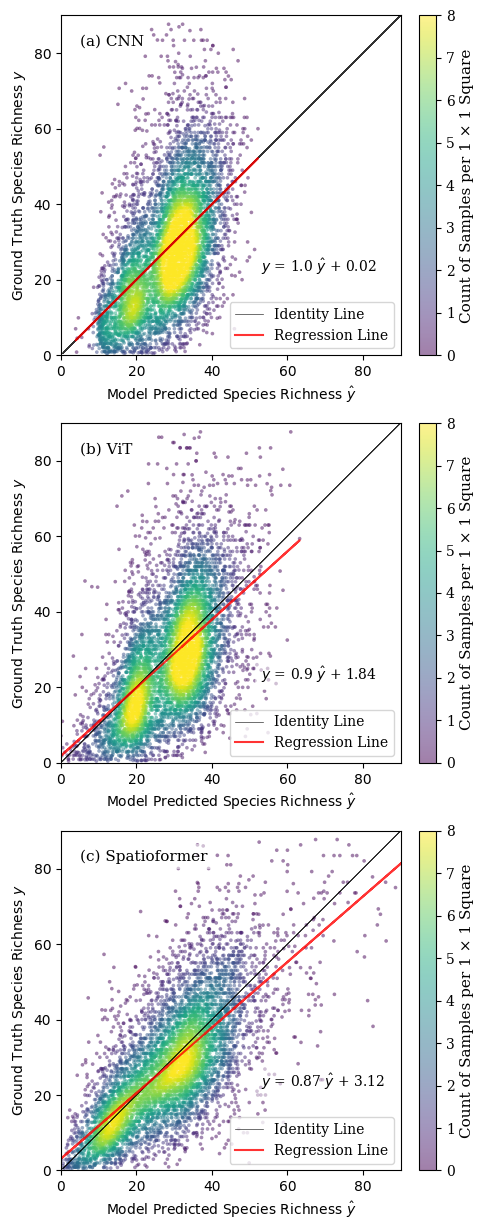

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 15))
plt.rcParams['font.family'] = 'DejaVu Serif'

slope, intercept,  _, _, _ = scipy.stats.linregress(np.array(predicted_cnn), np.array(true_cnn))
xy = np.vstack([np.array(predicted_cnn), np.array(true_cnn)])
z = gaussian_kde(xy)(xy) * 7016
ax1.plot(np.array(true_cnn), np.array(true_cnn), '-k', alpha=.8, label='Identity Line', linewidth=0.5)
ax1.plot(np.array(predicted_cnn), slope*np.array(predicted_cnn)+intercept, 'r', alpha=0.8, label='Regression Line')
sc = ax1.scatter(predicted_cnn, true_cnn, c=z, alpha=.5, s=7, linewidths=0, vmin=0, vmax=8)
clb = plt.colorbar(sc, fraction=0.046, pad=0.04)
clb.set_label('Count of Samples per 1 × 1 Square',fontsize=11)
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xticks([0, 20, 40, 60, 80])
ax1.set_yticks([0, 20, 40, 60, 80])
ax1.set_xlabel(r'Model Predicted Species Richness $\hat{{y}}$')
ax1.set_ylabel(r'Ground Truth Species Richness $y$')
ax1.legend(loc='lower right')
ax1.text(53, 22, r'$y$ = {} $\hat{{y}}$ + {}'.format(round(slope, 2), round(intercept, 2)), bbox=dict(facecolor='white', alpha=0.5, linewidth=0))
ax1.text(5, 82, '(a) CNN', fontsize=11, bbox=dict(facecolor='white', alpha=0.5, linewidth=0))

slope, intercept,  _, _, _ = scipy.stats.linregress(np.array(predicted_vit), np.array(true_vit))
xy = np.vstack([np.array(predicted_vit), np.array(true_vit)])
z = gaussian_kde(xy)(xy) * 7016
ax2.plot(np.array(true_vit), np.array(true_vit), '-k', alpha=.8, label='Identity Line', linewidth=0.5)
ax2.plot(np.array(predicted_vit), slope*np.array(predicted_vit)+intercept, 'r', alpha=0.8, label='Regression Line')
sc = ax2.scatter(predicted_vit, true_vit, c=z, alpha=.5, s=7, linewidths=0, vmin=0, vmax=8)
clb = plt.colorbar(sc, fraction=0.046, pad=0.04)
clb.set_label('Count of Samples per 1 × 1 Square',fontsize=11)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 90)
ax2.set_aspect('equal', adjustable='box')
ax2.set_xticks([0, 20, 40, 60, 80])
ax2.set_yticks([0, 20, 40, 60, 80])
ax2.set_xlabel(r'Model Predicted Species Richness $\hat{{y}}$')
ax2.set_ylabel(r'Ground Truth Species Richness $y$')
ax2.legend(loc='lower right')
ax2.text(53, 22, r'$y$ = {} $\hat{{y}}$ + {}'.format(round(slope, 2), round(intercept, 2)), bbox=dict(facecolor='white', alpha=0.5, linewidth=0))
ax2.text(5, 82, '(b) ViT', fontsize=11, bbox=dict(facecolor='white', alpha=0.5, linewidth=0))

slope, intercept,  _, _, _ = scipy.stats.linregress(np.array(predicted_spatioformer), np.array(true_spatioformer))
xy = np.vstack([np.array(predicted_spatioformer), np.array(true_spatioformer)])
z = gaussian_kde(xy)(xy) * 7016
ax3.plot(np.array(true_spatioformer), np.array(true_spatioformer), '-k', alpha=.8, label='Identity Line', linewidth=0.5)
ax3.plot(np.array(predicted_spatioformer), slope*np.array(predicted_spatioformer)+intercept, 'r', alpha=0.8, label='Regression Line')
sc = ax3.scatter(predicted_spatioformer, true_spatioformer, c=z, alpha=.5, s=7, linewidths=0, vmin=0, vmax=8)
clb = plt.colorbar(sc, fraction=0.046, pad=0.04)
clb.set_label('Count of Samples per 1 × 1 Square',fontsize=11)
ax3.set_xlim(0, 90)
ax3.set_ylim(0, 90)
ax3.set_aspect('equal', adjustable='box')
ax3.set_xticks([0, 20, 40, 60, 80])
ax3.set_yticks([0, 20, 40, 60, 80])
ax3.set_xlabel(r'Model Predicted Species Richness $\hat{{y}}$')
ax3.set_ylabel(r'Ground Truth Species Richness $y$')
ax3.legend(loc='lower right')
ax3.text(53, 22, r'$y$ = {} $\hat{{y}}$ + {}'.format(round(slope, 2), round(intercept, 2)), bbox=dict(facecolor='white', alpha=0.5, linewidth=0))
ax3.text(5, 82, '(c) Spatioformer', fontsize=11, bbox=dict(facecolor='white', alpha=0.5, linewidth=0))

In [8]:
fig.savefig('../figs/accuracy.jpg', bbox_inches='tight', dpi=300)